In [296]:
import os
os.chdir('/Users/mikelgallo/repos2/DeepL_test')

In [297]:
# imports
#Data Manipulation
import pandas as pd
import numpy as pd

#Model fitting, performance, balancing
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors 
from sklearn.model_selection import train_test_split
from Functions.helper_functions import *
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVR , SVC

In [298]:
#Defining repository path
#data_path = '/Users/mikelgallo/repos2/DeepL_test/Session 1_ Nearest Neighbors/'
data_path = './Session 1_ Nearest Neighbors/data/'

In [299]:
# Read data Train 
df = pd.read_csv(data_path+'mimic_train.csv')

# Read data Test
df_test = pd.read_csv(data_path+'mimic_test_death.csv')

In [300]:
#There is a large difference 
print(df.shape)
print(df_test.shape)

(20885, 44)
(5221, 39)


In [301]:
#Which is our dependent variable?
df['HOSPITAL_EXPIRE_FLAG'].unique()

array([0, 1])

In [302]:
# Select columns in test and add the Outcome variable to subset our train data set
df_test_cols = df_test.columns.tolist()
df_test_cols.append('HOSPITAL_EXPIRE_FLAG')

In [303]:
len(df_test_cols)

40

In [304]:
#Creating new subset
df_train= df[df_test_cols]

In [305]:
# The only column difference is our outcome variable
print(df_train.shape)
print(df_test.shape)

(20885, 40)
(5221, 39)


## Preprocessing

In [306]:
#STEP 1 - Split columns into Continuous, Discrete, Categorical
def numeric_cols(dataset):
    numeric = dataset.select_dtypes(include = np.number).columns.tolist()
    return numeric
#STEP 2 - Rough Estimate of Continuous and Discrete columns
def cont_or_disc(dataset,num):
    dict = {}
    numeric = numeric_cols(dataset)
    df_numeric = dataset[numeric]
    for i in df_numeric:
        count = df_numeric[i].count()
        unique_vals = len(df_numeric[i].unique())
        type = 'Discrete' if unique_vals < num else 'Continuous'
        dtype = df_numeric[i].dtype
        dict[i] = [count, unique_vals, type, dtype]
    result = pd.DataFrame.from_dict(dict,orient='index',columns=['count', 'unique_vals', 'type', 'dtype'])
    return result
#STEP 3 - Return column names for discrete and continuous    
def numeric_col_split(df,num):
    new_df = cont_or_disc(df,num)
    cont_cols = []
    disc_cols = []
    for index,row in new_df.iterrows():
        if row['type'] == 'Discrete':
            disc_cols.append(index)
        elif row['type'] == 'Continuous':
            cont_cols.append(index)
    return disc_cols, cont_cols        

In [307]:
#Return all numeric variables 
cont_or_disc(df_train,10)

,count,unique_vals,type,dtype
subject_id,20885,16317,Continuous,int64
hadm_id,20885,19749,Continuous,int64
icustay_id,20885,20885,Continuous,int64
HeartRate_Min,18698,132,Continuous,float64
HeartRate_Max,18698,165,Continuous,float64
HeartRate_Mean,18698,14092,Continuous,float64
SysBP_Min,18677,155,Continuous,float64
SysBP_Max,18677,191,Continuous,float64
SysBP_Mean,18677,13780,Continuous,float64
DiasBP_Min,18676,96,Continuous,float64


In [308]:
disc_cols, cont_cols  = numeric_col_split(df_train,10)

In [309]:
# Conitnuous columns
print('Continuous')
print(cont_cols)
# Discrete columns
print('Dsicrete')
print(disc_cols)

Continuous
['subject_id', 'hadm_id', 'icustay_id', 'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'Diff']
Dsicrete
['HOSPITAL_EXPIRE_FLAG']


In [310]:
## Check class balance of our outcome variable
## Train Data
df_train['HOSPITAL_EXPIRE_FLAG'].value_counts()

HOSPITAL_EXPIRE_FLAG
0    18540
1     2345
Name: count, dtype: int64

## continuous variables

In [311]:
df_train[cont_cols].describe()

,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,...,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,Diff
count,20885.000000,20885.000000,20885.000000,18698.000000,18698.000000,18698.000000,18677.000000,18677.000000,18677.000000,18676.000000,...,18388.000000,18388.000000,18388.000000,18682.000000,18682.000000,18682.000000,20632.000000,20632.000000,20632.000000,20885.000000
mean,58950.496098,150082.402298,250202.495523,69.705904,105.239801,85.180250,91.110564,150.725920,119.145423,44.327854,...,36.051208,37.428781,36.751717,91.007494,99.555883,96.866685,106.781975,182.129604,138.856428,-51617.069830
std,25299.439535,28898.479845,28909.806302,14.869840,20.922613,15.318208,17.532534,23.833793,16.701503,11.909852,...,0.732124,0.799897,0.603476,7.399390,1.159792,2.333108,35.178811,92.665603,44.933145,10686.395846
min,23.000000,100001.000000,200001.000000,2.000000,39.000000,34.714286,5.000000,46.000000,46.000000,4.000000,...,15.000000,30.800000,30.666667,1.000000,57.000000,47.666667,2.000000,42.000000,42.000000,-72740.274440
25%,41132.000000,125157.000000,225153.000000,60.000000,90.000000,74.272727,81.000000,134.000000,107.100000,37.000000,...,35.666667,36.944444,36.388889,90.000000,100.000000,95.812500,86.000000,126.000000,110.750000,-60864.454110
50%,60441.000000,150152.000000,250452.000000,69.000000,103.000000,84.131183,90.000000,148.000000,116.901961,44.000000,...,36.111111,37.333333,36.731481,92.000000,100.000000,97.142857,102.000000,161.000000,128.666667,-51561.703460
75%,80286.000000,175017.000000,275303.000000,79.000000,118.000000,95.185588,101.000000,164.000000,129.465116,51.000000,...,36.500000,37.888889,37.092593,94.000000,100.000000,98.346154,121.000000,206.000000,154.578571,-42327.560030
max,99999.000000,199999.000000,299998.000000,141.000000,280.000000,163.875000,181.000000,323.000000,202.172414,105.000000,...,40.100000,42.000000,40.238333,100.000000,100.000000,100.000000,563.000000,2440.000000,771.900000,-32157.494580


## Missing Values

In [312]:
## Getting columns with missing values
missing_cols = []
for i in df_train[cont_cols]:
    if df_train[i].isna().mean() > 0:
        missing_cols.append(i)
print(missing_cols)

['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean']


In [313]:
## Simple imputation of means
#missing_cols = df.columns
#for col  in missing_cols:
    #mean = df_train[col].mean()
    #df_train[col].fillna(mean,inplace=True)
    #df_test[col].fillna(mean,inplace=True)

In [341]:
df_train.isna().mean()

subject_id              0.0
hadm_id                 0.0
icustay_id              0.0
HeartRate_Min           0.0
HeartRate_Max           0.0
HeartRate_Mean          0.0
SysBP_Min               0.0
SysBP_Max               0.0
SysBP_Mean              0.0
DiasBP_Min              0.0
DiasBP_Max              0.0
DiasBP_Mean             0.0
MeanBP_Min              0.0
MeanBP_Max              0.0
MeanBP_Mean             0.0
RespRate_Min            0.0
RespRate_Max            0.0
RespRate_Mean           0.0
TempC_Min               0.0
TempC_Max               0.0
TempC_Mean              0.0
SpO2_Min                0.0
SpO2_Max                0.0
SpO2_Mean               0.0
Glucose_Min             0.0
Glucose_Max             0.0
Glucose_Mean            0.0
Diff                    0.0
HOSPITAL_EXPIRE_FLAG    0.0
dtype: float64

## KNN Imputation + SCALING

In [315]:
## Removing ID columns from continuous variables list
ID_list = ['subject_id', 'hadm_id', 'icustay_id']
new_cont_list = [col for col in cont_cols if col not in ID_list]
print(new_cont_list)

['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'Diff']


In [316]:
#Step 1 - Scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_train[new_cont_list])

df_train[new_cont_list] = scaler.transform(df_train[new_cont_list])
df_test[new_cont_list] = scaler.transform(df_test[new_cont_list])


/var/folders/pv/kfw019zx6lq5tdq_s52kkbzc0000gn/T/ipykernel_21931/4013778984.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[new_cont_list] = scaler.transform(df_train[new_cont_list])


In [317]:
# KNN imputation
from sklearn.impute import KNNImputer
# Create a KNNImputer object with k=3 
imputer = KNNImputer(n_neighbors=3) 

# Perform KNN imputation only on the specified columns for the training data
df_train[new_cont_list] = imputer.fit_transform(df_train[new_cont_list])

# Perform KNN imputation on the same columns for the test data (use the same imputer)
df_test[new_cont_list] = imputer.transform(df_test[new_cont_list])

/var/folders/pv/kfw019zx6lq5tdq_s52kkbzc0000gn/T/ipykernel_21931/2808671186.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[new_cont_list] = imputer.fit_transform(df_train[new_cont_list])


In [318]:
for i in df_train:
    if df_train[i].isna().mean() > 0:
        print(i,' : ', df_train[i].isna().mean())

MARITAL_STATUS  :  0.03457026574096241


## Creating Dummies

In [319]:
#def encode(df, columns_hot):
    #encoded_df = pd.get_dummies(df, columns=columns_hot, dtype=float)
    #return encoded_df
#E.g. df = encode(df, ['orientation', 'neighborhood'])

In [320]:
#df_train.columns

In [321]:
#df_train = encode(df_train,['MARITAL_STATUS'])
#df_test = encode(df_test,['MARITAL_STATUS'])

## Categoricals

In [322]:
# For now we are going to get rid of categoricals - except for Maritimal 
numerics = numeric_cols(df_train)
non_numeric = [col for col in df_train.columns if col not in numerics]

In [323]:
#Remove all non-numeric from datasets
df_train = df_train.drop(non_numeric,axis = 1)
df_test = df_test.drop(non_numeric,axis = 1)
#df = df.drop(['column'],axis=1)

In [324]:
df_test.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'HeartRate_Min', 'HeartRate_Max',
       'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min',
       'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
       'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
       'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'Diff'],
      dtype='object')

## Spliting Data

In [325]:
from sklearn.model_selection import train_test_split
# In case we use directly a Train and Test datatset
Xtrain = df_train.drop(['HOSPITAL_EXPIRE_FLAG','subject_id','hadm_id','icustay_id'],axis = 1)
ytrain = df_train['HOSPITAL_EXPIRE_FLAG']
Xtest_id = df_test[['icustay_id']]
Xtest = df_test.drop(['subject_id','hadm_id','icustay_id'],axis = 1) #probably it doesnt require to remove any column

In [327]:
print(Xtrain.shape)
print(Xtest.shape)

(20885, 25)
(5221, 25)


In [425]:
table = pd.DataFrame(ytrain.value_counts())
table = table.reset_index()
table

,HOSPITAL_EXPIRE_FLAG,count
0,0,18540
1,1,2345


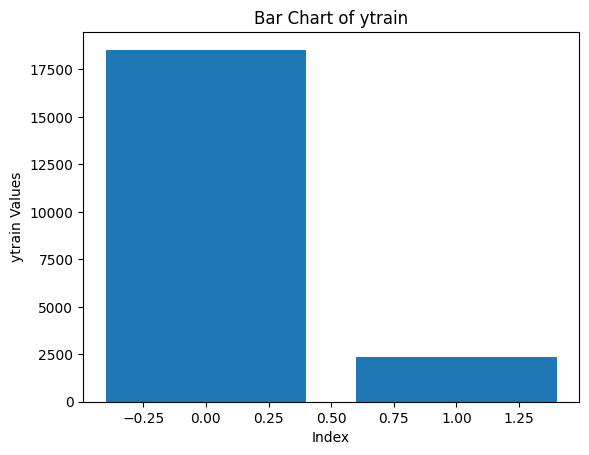

In [426]:

plt.bar(table['HOSPITAL_EXPIRE_FLAG'],table['count'])

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('ytrain Values')
plt.title('Bar Chart of ytrain')

# Display the plot
plt.show()

## Adjusting Class Imbalance

In [404]:
# PENDING
sampling_strategy = 0.5
ros = RandomOverSampler(sampling_strategy=sampling_strategy)
X_res, y_res = ros.fit_resample(Xtrain, ytrain)

In [429]:
table = pd.DataFrame(y_res.value_counts())
table = table.reset_index()
table

,HOSPITAL_EXPIRE_FLAG,count
0,0,18540
1,1,9270


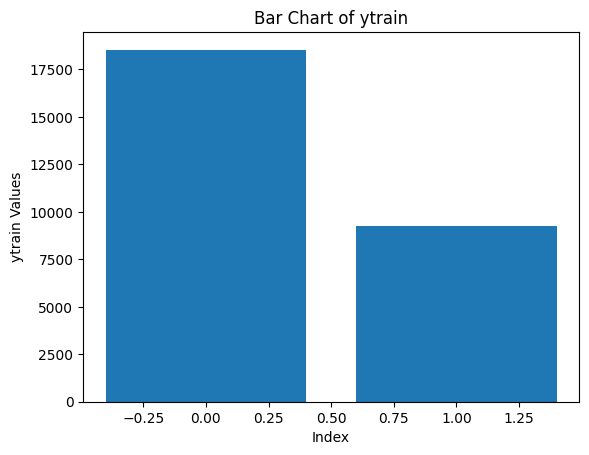

In [430]:

plt.bar(table['HOSPITAL_EXPIRE_FLAG'],table['count'])

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('ytrain Values')
plt.title('Bar Chart of ytrain')

# Display the plot
plt.show()

## Running a KNN (Creating a sample and checking for AUC score with different N-neighbors)

In [395]:
#Creating a train sample for our test

sample_size = 20000  # Adjust the sample size as needed

# Method 1: Using pandas sample method
sampled_data = df_train.sample(n=sample_size, random_state=42)

X_s = sampled_data.drop(['HOSPITAL_EXPIRE_FLAG','subject_id','hadm_id','icustay_id'],axis = 1)
y_s = sampled_data['HOSPITAL_EXPIRE_FLAG']

x_train, x_test, y_train, y_test = train_test_split(X_s, y_s, test_size=0.25)


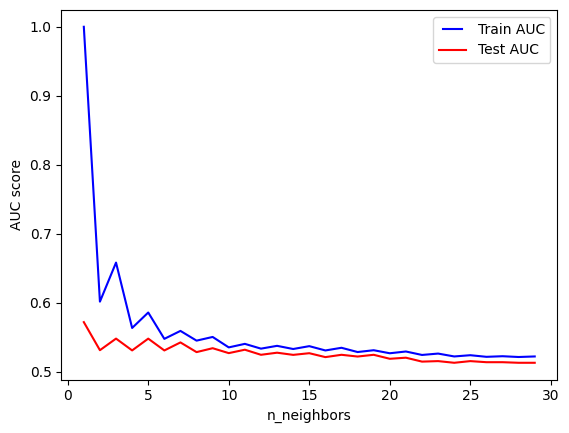

In [396]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
neighbors = list(range(1,30))

train_results = []
test_results = []
for n in neighbors:
   model = KNeighborsClassifier(n_neighbors=n, algorithm = 'brute',weights='uniform')
   model.fit(x_train, y_train)
   train_pred = model.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
    
   y_pred = model.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(neighbors, train_results, 'b', label='Train AUC')
line2, = plt.plot(neighbors, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_neighbors')
plt.show()

## Fitting simple KNN

In [377]:
# Step 1 - Create an instance of the KNN model
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier

KNN_model  = KNeighborsClassifier(n_neighbors=5, algorithm = 'brute',weights='distance')
KNN_model.fit(Xtrain,ytrain)

print(f"Predicted class is ",KNN_model.predict(Xtest))
## Check which other algorithm should we try

Predicted class is  [0 0 0 ... 0 0 0]


In [378]:
y_predict_proba = KNN_model.predict_proba(Xtest)

In [379]:
y_proba = pd.DataFrame(y_predict_proba[:,1])

In [380]:
# Produce .csv for kaggle testing
test_predictions_submit = pd.DataFrame({"icustay_id": Xtest_id['icustay_id'], "HOSPITAL_EXPIRE_FLAG": y_proba[0]})
test_predictions_submit.to_csv("test_predictions_submit_knn_5_weight_dist.csv", index = False)

## KNN Hypertuning RandomizedSearchCV

In [381]:
from sklearn.model_selection import RandomizedSearchCV
knn_model = KNeighborsClassifier(algorithm='brute')
param_dist = {'n_neighbors': [1, 2, 4, 5, 8, 10, 15, 20, 25], 'weights': ['uniform', 'distance']}
random_search = RandomizedSearchCV(knn_model, param_distributions=param_dist, scoring='roc_auc', n_iter=50, cv=5)

random_search.fit(Xtrain, ytrain)

print("Best Parameters:", random_search.best_params_)
print("Best ROC AUC Score:", random_search.best_score_)


/opt/anaconda3/envs/dl_env/lib/python3.12/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 18 is smaller than n_iter=50. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters: {'weights': 'distance', 'n_neighbors': 25}
Best ROC AUC Score: 0.7199787010394167


In [361]:
y_predict_rand_search_proba = random_search.predict_proba(Xtest)[:,1]

In [364]:
#Produce .csv for kaggle testing
test_predictions_submit = pd.DataFrame({"icustay_id": Xtest_id['icustay_id'], "HOSPITAL_EXPIRE_FLAG": y_predict_rand_search_proba[0]})
test_predictions_submit.to_csv("test_predictions_submit_random_search_KNN_RR.csv", index = False)

## KNN Hypertuning GridSearch CV

In [382]:
np.random.seed(42)
# Step 1 - Create an instance of the KNN model
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier

KNN_model  = KNeighborsClassifier(algorithm = 'brute')

# Step 2 - Create our grid_search_values
grid_values = {'n_neighbors': [1, 5, 10,15, 20, 25, 30, 35], 'weights': ['uniform','distance'], }
#grid_values = {'n_neighbors': [20,50, 70, 85, 100, 150, 200], 'weights': ['uniform','distance']}
#grid_values = {'n_neighbors': [100, 120, 200, 250, 300, 350], 'weights': ['uniform','distance']}
#grid_values = {'n_neighbors': [220, 230, 240, 250, 260], 'weights': ['uniform','distance']}
#grid_values = {'n_neighbors': [150, 200, 220, 250, 260], 'weights': ['uniform','distance']}



# Step 3 - Instanciate our gridSearch CV
grid_knn_acc = GridSearchCV(KNN_model, param_grid = grid_values, scoring='roc_auc',cv=20)

#Step 4 - fit model 
grid_knn_acc.fit(Xtrain,ytrain)

GridSearchCV(cv=20, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 5, 10, 15, 20, 25, 30, 35],
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc')

best parameters: {'n_neighbors': 35, 'weights': 'distance'}
best score:      0.72914 (+/-0.02773)


,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,...,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,mean_test_score,std_test_score,rank_test_score
15,35,distance,"{'n_neighbors': 35, 'weights': 'distance'}",0.693315,0.711412,0.755892,0.723100,0.705506,0.736186,0.697273,...,0.764865,0.730359,0.739358,0.730317,0.724251,0.717363,0.731502,0.729141,0.027729,1
14,35,uniform,"{'n_neighbors': 35, 'weights': 'uniform'}",0.694371,0.713848,0.757396,0.723562,0.704898,0.737325,0.692815,...,0.755682,0.734881,0.730806,0.729575,0.723467,0.714270,0.724836,0.727566,0.029473,2
13,30,distance,"{'n_neighbors': 30, 'weights': 'distance'}",0.686432,0.707376,0.747244,0.714753,0.702028,0.725311,0.702726,...,0.768203,0.716981,0.731152,0.731106,0.722881,0.720853,0.727865,0.724077,0.024909,3
12,30,uniform,"{'n_neighbors': 30, 'weights': 'uniform'}",0.686107,0.709172,0.749387,0.714132,0.702119,0.728441,0.700901,...,0.761666,0.722743,0.725297,0.733480,0.720931,0.718636,0.720300,0.722942,0.025899,4
11,25,distance,"{'n_neighbors': 25, 'weights': 'distance'}",0.677317,0.690943,0.729883,0.702924,0.693535,0.723748,0.700716,...,0.769198,0.707788,0.737237,0.720756,0.716086,0.716049,0.726016,0.718339,0.026082,5
10,25,uniform,"{'n_neighbors': 25, 'weights': 'uniform'}",0.674273,0.694934,0.727141,0.697297,0.689037,0.727270,0.700845,...,0.760495,0.713998,0.734042,0.719548,0.710882,0.712191,0.721890,0.716634,0.026707,6
9,20,distance,"{'n_neighbors': 20, 'weights': 'distance'}",0.675886,0.686116,0.722387,0.699738,0.698188,0.714012,0.673637,...,0.761560,0.697397,0.722817,0.714399,0.713025,0.703529,0.723379,0.708276,0.024051,7
8,20,uniform,"{'n_neighbors': 20, 'weights': 'uniform'}",0.668513,0.688516,0.725486,0.694883,0.691693,0.720134,0.669331,...,0.750758,0.699776,0.719193,0.707373,0.710029,0.695558,0.715648,0.704635,0.024971,8
7,15,distance,"{'n_neighbors': 15, 'weights': 'distance'}",0.663814,0.670054,0.702174,0.697745,0.690015,0.698079,0.671378,...,0.752607,0.701251,0.707659,0.709291,0.711052,0.699684,0.715671,0.698990,0.021765,9
6,15,uniform,"{'n_neighbors': 15, 'weights': 'uniform'}",0.661140,0.674337,0.698430,0.695683,0.688210,0.702832,0.666561,...,0.742635,0.713325,0.706184,0.705184,0.709462,0.691404,0.709895,0.696311,0.021924,10


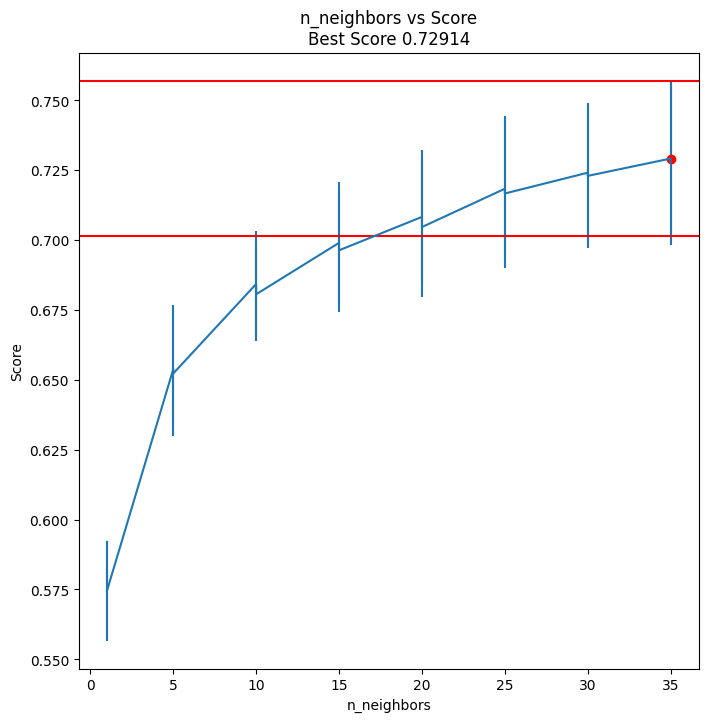

In [383]:
# Report best Number of Neighbors
GridSearch_table_plot(grid_knn_acc, "n_neighbors", negative=False, display_all_params=False)

In [213]:
#Best Result
print('best parameters:', grid_knn_acc.best_params_)
print('best score:', grid_knn_acc.best_score_)

best parameters: {'n_neighbors': 42, 'weights': 'distance'}
best score: 0.732960277811767


In [214]:
y_predict_grids_proba = grid_knn_acc.predict_proba(Xtest)[:,1]

In [215]:
y_predict_grids_proba

array([0.02170072, 0.16295195, 0.        , ..., 0.02391794, 0.        ,
       0.024201  ])

In [216]:
# Produce .csv for kaggle testing
test_predictions_submit_knn_grid = pd.DataFrame({"icustay_id": Xtest_id['icustay_id'], "HOSPITAL_EXPIRE_FLAG": y_predict_grids_proba[0]})
test_predictions_submit_knn_grid.to_csv("test_predictions_submit_knn_imputation3.csv", index = False)

## Running a SVM

In [272]:
# Create a Support Vector Machine classifier with a linear kernel
classifier = SVC(kernel='rbf', probability=True)

# Train the classifier on the training set
classifier.fit(Xtrain, ytrain)

# Obtain decision values or probabilities on the training set
#y_train_scores = classifier.decision_function(X_train_scaled)  # Use decision_function for linear kernel
# Alternatively, you can use predict_proba for non-linear kernels
y_train_probs = classifier.predict_proba(Xtest)[:, 1]

# Calculate AUC score on the training set
#auc_score_train = roc_auc_score(y_train, y_train_scores)

# Print or use the AUC score as needed
#print("AUC score on the training set:", auc_score_train)

In [274]:
len(y_train_probs)

5221

In [275]:
# Produce .csv for kaggle testing
test_predictions_submit_SVM = pd.DataFrame({"icustay_id": Xtest_id['icustay_id'], "HOSPITAL_EXPIRE_FLAG": y_train_probs[0]})
test_predictions_submit_SVM.to_csv("test_predictions_submit_svm.csv", index = False)